In [1]:
%matplotlib inline

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import scale as mscale
from matplotlib import transforms as mtransforms
import matplotlib.cm as cm

from matplotlib import pyplot as plt
from scipy.stats import binom
from utils import *

In [2]:
# Write some stuff to csv for SI
small_log_df.to_csv('fig2/Fig2S1.csv')

big_diff_df

,locusId,sysName,desc,HighCO2Log_1,LowCO2Log_1,HighCO2Log_2,LowCO2Log_2,hcr
189,HNEAP_RS01030,HNEAP_RS01030,DUF2309 domain-containing protein,-0.009401,-2.953393,-0.026934,-2.713515,True
190,HNEAP_RS01035,HNEAP_RS01035,NADH dehydrogenase subunit 5,0.052684,-3.018988,-0.088164,-2.763632,True
191,HNEAP_RS01040,HNEAP_RS01040,LysR family transcriptional regulator,0.104180,-2.532413,-0.066607,-2.515328,True
636,HNEAP_RS04585,HNEAP_RS04585,DUF2309 domain-containing protein,-0.432006,-1.521512,-0.441381,-1.597535,True
638,HNEAP_RS04595,HNEAP_RS04595,oxidoreductase,-0.300871,-1.602699,-0.301030,-1.668806,True
642,HNEAP_RS04615,HNEAP_RS04615,hypothetical protein,-0.350162,-4.689306,-0.599468,-3.395316,True
643,HNEAP_RS04620,HNEAP_RS04620,major carboxysome shell protein 1B,-0.418130,-1.635895,0.043933,-1.366680,True
644,HNEAP_RS04625,HNEAP_RS04625,major carboxysome shell protein 1A,0.118381,-4.740660,0.064914,-4.307387,True
645,HNEAP_RS04630,HNEAP_RS04630,major carboxysome shell protein 1C,-0.148564,-6.831912,-0.080212,-6.469368,True
646,HNEAP_RS04635,HNEAP_RS04635,carboxysome peptide B,0.008628,-5.841639,0.124864,-6.077559,True


In [3]:
essentiality_colors = {
    'essential': qual_palette[9],
    'nonessential': qual_palette[3],
    'ambiguous': qual_palette[7], 
    'hcr': qual_palette[8]}

/usr/local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


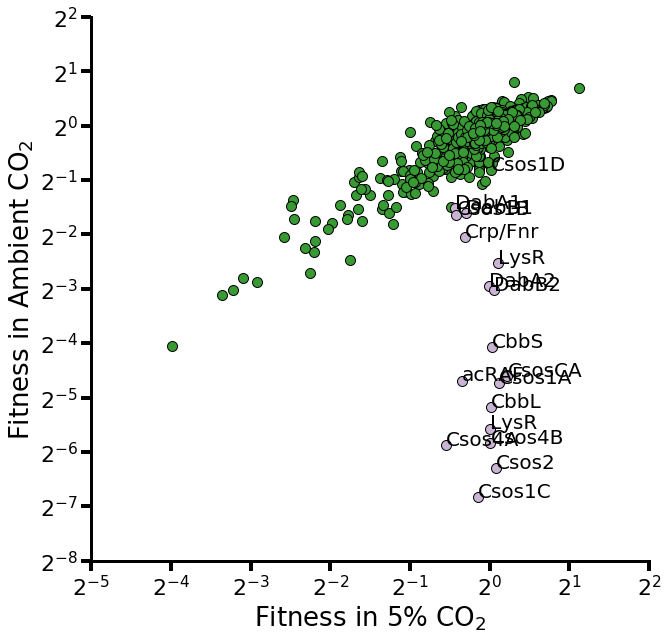

In [4]:
# TODO(JD): move annotations a bit for clarity
iCol = essentiality_colors['nonessential']
aCol = essentiality_colors['hcr']

fig,ax = plt.subplots(figsize=(10,10), frameon=False)

labeled_stuff = [
    ('HNEAP_RS04625', 'Csos1A', 0.11,-4.5),
    ('HNEAP_RS04620', 'Csos1B', -0.1,-1.6),
    ('HNEAP_RS04630', 'Csos1C', 0,-7),
    ('HNEAP_RS04635', 'Csos4B', 0.1,-5.9),
    ('HNEAP_RS04640', 'Csos4A', -1.5,-6.5),
    ('HNEAP_RS04650', 'Csos2', 0.1,-6.4),
    ('HNEAP_RS04660', 'CbbL', -0.9,-5.2),
    ('HNEAP_RS04655', 'CbbS', 0,-4.1),
    ('HNEAP_RS04645', 'CsosCA', 0.15,-5),
    ('HNEAP_RS04565','Csos1D', -0.05,-1.15),
    ('HNEAP_RS01030','DabA2', 0.1,-3.3),
        ('HNEAP_RS01035','DabB2',1,1),
    ('HNEAP_RS01040','LysR', 0.15,-2.6),
    ('HNEAP_RS04615','acRAF', -1.5,-4), #Pterin-4a-carbinolamine dehydratase
    ('HNEAP_RS05490','LysR', -0.8,-6),
    ('HNEAP_RS07320','Crp/Fnr', 0,-2.1),
    ('HNEAP_RS04585','DabA1', -1.5,-2.1),
        ('HNEAP_RS04595','DabB1',1,1),
#         ('HNEAP_RS05865','TPR_16',1,1),#Tetratricopeptide TPR_2 repeat protein
#     'HNEAP_RS05380':'Lytic transglycosylase catalytic',
#     'HNEAP_RS08465':'N-acetylmuramyl-L-alanine amidase, negative regulator of AmpC, AmpD'
]

for gene,label,x,y in labeled_stuff:
    row = small_log_df[small_log_df.locusId == gene]
    plt.text(row.HighCO2Log_1,row.LowCO2Log_1,label,fontsize=20)

plt.scatter(small_diff_df.HighCO2Log_1, small_diff_df.LowCO2Log_1, c=iCol, edgecolors='k', s=100)
plt.scatter(big_diff_df.HighCO2Log_1, big_diff_df.LowCO2Log_1, c=aCol, edgecolors='k', s=100)


plt.xlabel('Fitness in 5% CO$_2$')
plt.ylabel('Fitness in Ambient CO$_2$')
plt.tick_params(axis='both', direction='out', bottom='on', left='on', top='off', right='off',
                length=10, width=4)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# change axis weight
ax.spines['left'].set_linewidth(3)
ax.spines['bottom'].set_linewidth(3)

locs,labels = plt.xticks()
ticks=['2$^{'+str(int(x))+'}$' for x in locs]
plt.xticks(locs, ticks, fontsize=22)

locs,labels = plt.yticks()
ticks=['2$^{'+str(int(x))+'}$' for x in locs]
plt.yticks(locs,ticks, fontsize=22)
        
plt.savefig('fig2/fig2B.eps',format='eps',bbox_inches='tight')
plt.show()

In [5]:
# TODO(JD): put annotations in here for figures below.
short_names = {'HNEAP_RS04610': 'ParA',
               'HNEAP_RS04615': 'acRAF',
               'HNEAP_RS04635': 'csos4B',
               'HNEAP_RS04605': 'unk.',
               'HNEAP_RS04585': 'DabA1',
               'HNEAP_RS04575': 'CbbQ',
               'HNEAP_RS04580': 'P-II',
               'HNEAP_RS04680': 'unk.',
               'HNEAP_RS04620': 'csos1B',
               'HNEAP_RS04625': 'csos1A',
               'HNEAP_RS04675': 'transporter',
               'HNEAP_RS04565': 'csos1D',
               'HNEAP_RS04685': 'NnrS',
               'HNEAP_RS04640': 'csos4A',
               'HNEAP_RS04600': 'cbbO',
               'HNEAP_RS04645': 'csoCA',
               'HNEAP_RS04555': 'TS',
               'HNEAP_RS04690': 'unk.',
               'HNEAP_RS04670': 'DUF302',
               'HNEAP_RS04595': 'DabB1',
               'HNEAP_RS04655': 'rbcS',
               'HNEAP_RS04570': 'unk.',
               'HNEAP_RS04630': 'csos1C',
               'HNEAP_RS04665': 'Cu-transporter',
               'HNEAP_RS04560': 'lgt',
               'HNEAP_RS04660': 'rbcL',
               'HNEAP_RS04590': 'unk.',
               'HNEAP_RS04650': 'csos2',
               'HNEAP_RS01020': 'GLUL',
               'HNEAP_RS01065': 'DUF839',
               'HNEAP_RS01030': 'DabA2',
               'HNEAP_RS01045': 'DUF3817',
               'HNEAP_RS01010': 'DNA-binding',
               'HNEAP_RS01050': 'PTH',
               'HNEAP_RS01025': 'TspO',
               'HNEAP_RS01055': 'unk.',
               'HNEAP_RS01015': 'kinase',
               'HNEAP_RS01035': 'DabB2',
               'HNEAP_RS01060': 'thioredoxin',
               'HNEAP_RS01040': 'LysR',
               'HNEAP_RS07310': 'unk.',
               'HNEAP_RS07320': 'Crp/Fnr',
               'HNEAP_RS07315': 'unk.',
               'HNEAP_RS07325': 'PP-ase',
               'HNEAP_RS05485': 'tRNA-Met',
               'HNEAP_RS12520': 'unk.',
               'HNEAP_RS05495': 'VWA',
               'HNEAP_RS05480': 'diguanylate cyclase',
               'HNEAP_RS05490': 'LysR'}

essentiality_colors = {
    'essential': qual_palette[9],
    'nonessential': qual_palette[3],
    'ambiguous': qual_palette[7], 
    'hcr': qual_palette[8]}

/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


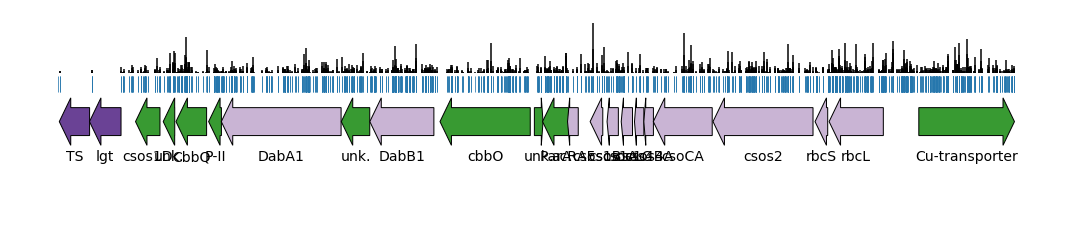

In [6]:
# Making Panel B

fig,ax = plt.subplots(figsize=(15, 3.5), frameon=False)

plt.ylim(0, 0.4)
region = (983594-14000,986794+8000)
y = 0.2

insert_color = qual_palette[1]

# Arrow parameters
width = 0.05
headwidth = 0.085
height = 1e-5
head_scale = 0.2
len_per_bp = 1e-4

region_start, region_end = region
region_length = region_end - region_start

genes_in_region = essentiality_df[(essentiality_df.begin >= region_start) & 
                                  (essentiality_df.end <= region_end)]
insert_in_region = total_pool_df[(total_pool_df.pos >= region_start) & 
                                 (total_pool_df.pos <= region_end)]

for gene_idx in genes_in_region.index:
    gene = genes_in_region.loc[gene_idx]
    gene_name = short_names[gene.locusId]
#     print(gene_name)
    gene_length = gene.length_rep1
    gene_essentiality = essentiality_df.loc[gene_idx].essentiality
    length = gene_length * len_per_bp
    head_length = length*head_scale
    if length > 0.03:
        head_length = 0.03
    c = essentiality_colors[gene_essentiality]
    
    is_hcr = (small_log_df[small_log_df.locusId == gene.locusId].hcr).any()
    if is_hcr:
        c = essentiality_colors['hcr']

    gene_start = gene.begin
    gene_end = gene.end
    gene_strand = gene.strand

    if gene_strand == '+':
        start = (gene_start - region_start)*len_per_bp
        genePic = matplotlib.patches.FancyArrow(
            start, y, length, 0,
            width=width, length_includes_head=True,
            head_width=headwidth, head_length=head_length, fill=True, facecolor=c)
        ax.add_artist(genePic)
        plt.text(start+length/2, y-0.07, gene_name, ha='center', fontsize=14)
    else:
        start = (gene_end - region_start) * len_per_bp
        genePic = matplotlib.patches.FancyArrow(
            start, y, -length, 0,
            width=width, length_includes_head=True,
            head_width=headwidth,
            head_length=head_length, fill=True,facecolor=c)
        ax.add_artist(genePic)
        plt.text(start-length/2, y-0.07, gene_name, ha='center', fontsize=14)

poses = (insert_in_region.pos - region_start) * len_per_bp
n_positions = len(poses)

bottoms = [y+height+headwidth/2 + 0.045]*n_positions
tops = bottoms + (height*insert_in_region.n_total)
plt.vlines(poses, bottoms, tops, colors='k')

bottoms = np.array([y+height+headwidth/2+0.01]*n_positions)
tops = bottoms + 0.03
plt.vlines(poses, tops, bottoms, colors=insert_color, linewidth=0.75)

# print(dict(zip(genes_in_region.locusId, genes_in_region.desc)))
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.tight_layout()

plt.savefig('fig2/fig2C_sub1.eps', format='eps', bbox_inches='tight')
plt.show()

/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


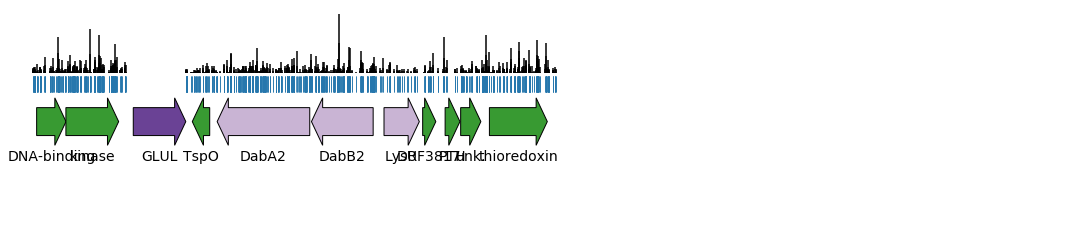

In [7]:
# Making Panel B

fig,ax = plt.subplots(figsize=(15, 3.5), frameon=False)

plt.ylim(0, 0.4)
region = (216936-5000,219419+6600)
y = 0.2

insert_color = qual_palette[1]

# Arrow parameters
width = 0.05
headwidth = 0.085
height = 1e-5
head_scale = 0.2
len_per_bp = 1e-4

region_start, region_end = region
region_length = region_end - region_start

genes_in_region = essentiality_df[(essentiality_df.begin >= region_start) & 
                                  (essentiality_df.end <= region_end)]
insert_in_region = total_pool_df[(total_pool_df.pos >= region_start) & 
                                 (total_pool_df.pos <= region_end)]

for gene_idx in genes_in_region.index:
    gene = genes_in_region.loc[gene_idx]
    gene_name = short_names[gene.locusId]
    gene_length = gene.length_rep1
    gene_essentiality = essentiality_df.loc[gene_idx].essentiality
    length = gene_length * len_per_bp
    head_length = length*head_scale
    if length > 0.03:
        head_length = 0.03
    c = essentiality_colors[gene_essentiality]
    
    is_hcr = (small_log_df[small_log_df.locusId == gene.locusId].hcr).any()
    if is_hcr:
        c = essentiality_colors['hcr']

    gene_start = gene.begin
    gene_end = gene.end
    gene_strand = gene.strand

    if gene_strand == '+':
        start = (gene_start - region_start)*len_per_bp
        genePic = matplotlib.patches.FancyArrow(
            start, y, length, 0,
            width=width, length_includes_head=True,
            head_width=headwidth, head_length=head_length, fill=True, facecolor=c)
        ax.add_artist(genePic)
        plt.text(start+length/2, y-0.07, gene_name, ha='center', fontsize=14)
    else:
        start = (gene_end - region_start) * len_per_bp
        genePic = matplotlib.patches.FancyArrow(
            start, y, -length, 0,
            width=width, length_includes_head=True,
            head_width=headwidth,
            head_length=head_length, fill=True,facecolor=c)
        ax.add_artist(genePic)
        plt.text(start-length/2, y-0.07, gene_name, ha='center', fontsize=14)

poses = (insert_in_region.pos - region_start) * len_per_bp
n_positions = len(poses)

bottoms = [y+height+headwidth/2 + 0.045]*n_positions
tops = bottoms + (height*insert_in_region.n_total)
plt.vlines(poses, bottoms, tops, colors='k')

bottoms = np.array([y+height+headwidth/2+0.01]*n_positions)
tops = bottoms + 0.03
plt.vlines(poses, tops, bottoms, colors=insert_color, linewidth=0.75)

# print(dict(zip(genes_in_region.locusId, genes_in_region.desc)))



ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

length_longer_axis = ((986794+11000)- (983594-14000))*len_per_bp

plt.xlim(0,length_longer_axis)
plt.tight_layout()

plt.savefig('fig2/fig1C_sub2.eps', format='eps', bbox_inches='tight')
plt.show()

In [8]:
essentiality_df[essentiality_df.locusId.isin(['HNEAP_RS05490','HNEAP_RS07320'])]

,Unnamed: 0,locusId,sysName,type,scaffoldId,begin,end,strand,name,desc,...,nTA,pval_raw_rep1,pval_corr_rep1,length_rep1,n_inserts_rep1,pval_raw_rep2,pval_corr_rep2,length_rep2,n_inserts_rep2,essentiality
1089,1089,HNEAP_RS05490,HNEAP_RS05490,1,NC_013422.1,1179635,1180537,+,NaN,LysR family transcriptional regulator,...,31,0.074057,178.329436,902.0,27.0,0.050014,120.434438,902.0,25.0,nonessential
1460,1460,HNEAP_RS07320,HNEAP_RS07320,1,NC_013422.1,1575176,1575778,+,NaN,hypothetical protein,...,17,0.317394,764.284556,602.0,21.0,0.293216,706.064741,602.0,20.0,nonessential


{'HNEAP_RS05480': 'sensor domain-containing diguanylate cyclase', 'HNEAP_RS05485': 'tRNA-Met', 'HNEAP_RS05490': 'LysR family transcriptional regulator', 'HNEAP_RS05495': 'VWA domain-containing protein', 'HNEAP_RS12520': 'hypothetical protein'}


/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


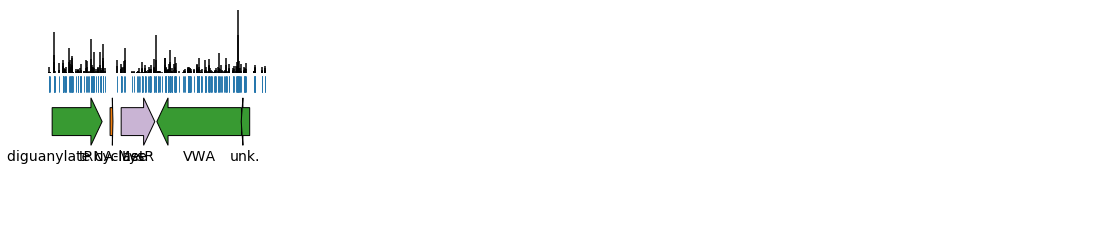

In [9]:
# Making Panel B

fig,ax = plt.subplots(figsize=(15, 3.5), frameon=False)

plt.ylim(0, 0.4)
region = (1179635-2000,1180537+3000)
y = 0.2

insert_color = qual_palette[1]

# Arrow parameters
width = 0.05
headwidth = 0.085
height = 1e-5
head_scale = 0.2
len_per_bp = 1e-4

region_start, region_end = region
region_length = region_end - region_start

genes_in_region = essentiality_df[(essentiality_df.begin >= region_start) & 
                                  (essentiality_df.end <= region_end)]
insert_in_region = total_pool_df[(total_pool_df.pos >= region_start) & 
                                 (total_pool_df.pos <= region_end)]

for gene_idx in genes_in_region.index:
    gene = genes_in_region.loc[gene_idx]
#     gene_name = short_names[gene.locusId]
    gene_name = short_names.get(gene.locusId, 'Unk.')
    gene_length = gene.length_rep1
    gene_essentiality = essentiality_df.loc[gene_idx].essentiality
    length = gene_length * len_per_bp
    head_length = length*head_scale
    if length > 0.03:
        head_length = 0.03
    c = essentiality_colors[gene_essentiality]
    
    is_hcr = (small_log_df[small_log_df.locusId == gene.locusId].hcr).any()
    if is_hcr:
        c = essentiality_colors['hcr']

    gene_start = gene.begin
    gene_end = gene.end
    gene_strand = gene.strand

    if gene_strand == '+':
        start = (gene_start - region_start)*len_per_bp
        genePic = matplotlib.patches.FancyArrow(
            start, y, length, 0,
            width=width, length_includes_head=True,
            head_width=headwidth, head_length=head_length, fill=True, facecolor=c)
        ax.add_artist(genePic)
        plt.text(start+length/2, y-0.07, gene_name, ha='center', fontsize=14)
    else:
        start = (gene_end - region_start) * len_per_bp
        genePic = matplotlib.patches.FancyArrow(
            start, y, -length, 0,
            width=width, length_includes_head=True,
            head_width=headwidth,
            head_length=head_length, fill=True,facecolor=c)
        ax.add_artist(genePic)
        plt.text(start-length/2, y-0.07, gene_name, ha='center', fontsize=14)

poses = (insert_in_region.pos - region_start) * len_per_bp
n_positions = len(poses)

bottoms = [y+height+headwidth/2 + 0.045]*n_positions
tops = bottoms + (height*insert_in_region.n_total)
plt.vlines(poses, bottoms, tops, colors='k')

bottoms = np.array([y+height+headwidth/2+0.01]*n_positions)
tops = bottoms + 0.03
plt.vlines(poses, tops, bottoms, colors=insert_color, linewidth=0.75)

print(dict(zip(genes_in_region.locusId, genes_in_region.desc)))



ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

length_longer_axis = ((986794+11000)- (983594-14000))*len_per_bp

plt.xlim(0,length_longer_axis)
plt.tight_layout()

plt.savefig('fig2/fig1C_sub3.eps', format='eps', bbox_inches='tight')
plt.show()

{'HNEAP_RS07310': 'hypothetical protein', 'HNEAP_RS07315': 'hypothetical protein', 'HNEAP_RS07320': 'hypothetical protein', 'HNEAP_RS07325': 'diguanylate phosphodiesterase'}


/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


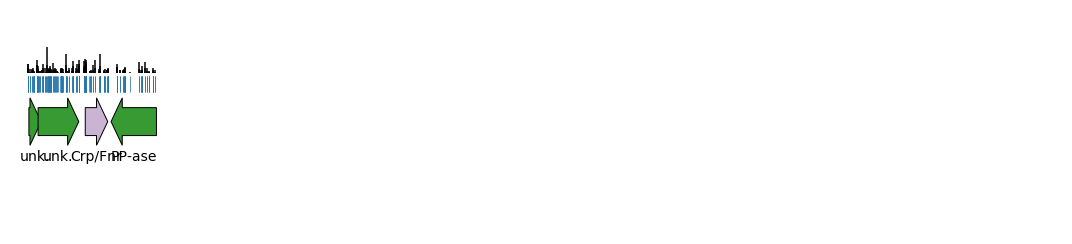

In [10]:
# Making Panel B

fig,ax = plt.subplots(figsize=(15, 3.5), frameon=False)

plt.ylim(0, 0.4)
region = (1575176 -2000,1575778+1350)
y = 0.2

insert_color = qual_palette[1]

# Arrow parameters
width = 0.05
headwidth = 0.085
height = 1e-5
head_scale = 0.2
len_per_bp = 1e-4

region_start, region_end = region
region_length = region_end - region_start

genes_in_region = essentiality_df[(essentiality_df.begin >= region_start) & 
                                  (essentiality_df.end <= region_end)]
insert_in_region = total_pool_df[(total_pool_df.pos >= region_start) & 
                                 (total_pool_df.pos <= region_end)]

for gene_idx in genes_in_region.index:
    gene = genes_in_region.loc[gene_idx]
#     gene_name = short_names[gene.locusId]
    gene_name = short_names.get(gene.locusId, 'Unk.')
    gene_length = gene.length_rep1
    gene_essentiality = essentiality_df.loc[gene_idx].essentiality
    length = gene_length * len_per_bp
    head_length = length*head_scale
    if length > 0.03:
        head_length = 0.03
    c = essentiality_colors[gene_essentiality]
    
    is_hcr = (small_log_df[small_log_df.locusId == gene.locusId].hcr).any()
    if is_hcr:
        c = essentiality_colors['hcr']

    gene_start = gene.begin
    gene_end = gene.end
    gene_strand = gene.strand

    if gene_strand == '+':
        start = (gene_start - region_start)*len_per_bp
        genePic = matplotlib.patches.FancyArrow(
            start, y, length, 0,
            width=width, length_includes_head=True,
            head_width=headwidth, head_length=head_length, fill=True, facecolor=c)
        ax.add_artist(genePic)
        plt.text(start+length/2, y-0.07, gene_name, ha='center', fontsize=14)
    else:
        start = (gene_end - region_start) * len_per_bp
        genePic = matplotlib.patches.FancyArrow(
            start, y, -length, 0,
            width=width, length_includes_head=True,
            head_width=headwidth,
            head_length=head_length, fill=True,facecolor=c)
        ax.add_artist(genePic)
        plt.text(start-length/2, y-0.07, gene_name, ha='center', fontsize=14)

poses = (insert_in_region.pos - region_start) * len_per_bp
n_positions = len(poses)

bottoms = [y+height+headwidth/2 + 0.045]*n_positions
tops = bottoms + (height*insert_in_region.n_total)
plt.vlines(poses, bottoms, tops, colors='k')

bottoms = np.array([y+height+headwidth/2+0.01]*n_positions)
tops = bottoms + 0.03
plt.vlines(poses, tops, bottoms, colors=insert_color, linewidth=0.75)

ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

length_longer_axis = ((986794+11000)- (983594-14000))*len_per_bp

plt.xlim(0,length_longer_axis)
plt.tight_layout()

plt.savefig('fig2/fig1C_sub4.eps', format='eps', bbox_inches='tight')
plt.show()